In [1]:
import apache_beam   # Needs to be imported separately to avoid TypingError
import weatherbench2
import xarray as xr
from weatherbench2 import config
import numpy as np

In [2]:
forecast_path = 'gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_with_poles_conservative.zarr'
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_with_poles_conservative.zarr'
climatology_path = 'gs://weatherbench2/datasets/era5-hourly-climatology/1990-2019_6h_64x32_equiangular_with_poles_conservative.zarr'

In [3]:
observations = xr.open_zarr(obs_path)
forecast_example = xr.open_zarr(forecast_path)
forecast_example["geopotential"].sel(time=slice('2020-01-01', '2020-12-31')).values


array([[[[[ 2.02027438e+05,  2.01660625e+05,  2.01250000e+05, ...,
            1.85831453e+05,  1.85135453e+05,  1.85490047e+05],
          [ 2.02021094e+05,  2.01637188e+05,  2.01204469e+05, ...,
            1.85717734e+05,  1.85094516e+05,  1.85477453e+05],
          [ 2.02017078e+05,  2.01618812e+05,  2.01179031e+05, ...,
            1.85579000e+05,  1.85060062e+05,  1.85459766e+05],
          ...,
          [ 2.02057422e+05,  2.01759578e+05,  2.01466234e+05, ...,
            1.86060141e+05,  1.85313078e+05,  1.85564750e+05],
          [ 2.02045375e+05,  2.01720203e+05,  2.01373984e+05, ...,
            1.85981812e+05,  1.85245328e+05,  1.85538328e+05],
          [ 2.02035406e+05,  2.01688250e+05,  2.01307781e+05, ...,
            1.85918438e+05,  1.85184531e+05,  1.85511297e+05]],

         [[ 1.55421906e+05,  1.55176594e+05,  1.54955141e+05, ...,
            1.46750047e+05,  1.45917672e+05,  1.46081391e+05],
          [ 1.55416812e+05,  1.55145719e+05,  1.54879641e+05, ...,
      

In [4]:
# Splitting test and train set for simplified climatology model 
import xarray as xr

# Load your observations dataset using xr.open_zarr
# (Assuming you've loaded the dataset as 'observations')

# Define the time range for the training and test sets

start_date_train = '1959-01-02'
end_date_train = '2019-12-31'
start_date_test = '2020-01-01'
end_date_test = '2020-01-02'

# Split the dataset based on time
train_data = observations.sel(time=slice(start_date_train, end_date_train))
test_data = observations.sel(time=slice(start_date_test, end_date_test))

def simple_model(training_data, date_to_predict, data_variable):
    climatology = training_data.groupby('time.dayofyear').mean('time')
    # Extract the day of the year from the datetime
    day_of_year = date_to_predict.dt.dayofyear
    prediction = climatology[data_variable].sel(dayofyear=day_of_year)
    prediction = prediction.expand_dims({'time': [date_to_predict.values]})  
    lead_time = np.array(forecast_example["prediction_timedelta"], dtype='timedelta64[ns]')
    prediction = prediction.expand_dims({'prediction_timedelta': lead_time}) 
    return prediction

train_data


<xarray.Dataset>
Dimensions:                                           (time: 89116,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 -90....
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float64 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    ...                                                ...
    type_of_high_vegetation                           (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    type_of_low_vegetation                            (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    u_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    vertical_velocity                                 (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>

In [14]:
# Splitting test and train set for simplified climatology model 
import xarray as xr

# Load your observations dataset using xr.open_zarr
# (Assuming you've loaded the dataset as 'observations')

# Define the time range for the training and test sets

start_date_train = '1959-01-02'
end_date_train = '2019-12-31'
start_date_test = '2020-01-01'
end_date_test = '2020-01-02'

# Split the dataset based on time
train_data = observations.sel(time=slice(start_date_train, end_date_train))
test_data = observations.sel(time=slice(start_date_test, end_date_test))

def simple_model(training_data, date_to_predict, data_variable, lead_time):
    climatology = training_data.groupby('time.dayofyear').mean('time')
    
    # Extract the day of the year from the datetime
    day_of_year = date_to_predict.dt.dayofyear
    
    # Calculate the target date by adding the lead time in seconds
    target_date = date_to_predict + np.timedelta64(lead_time, 'ns')
    
    # Extract the day of the year for the target date
    target_day_of_year = target_date.dt.dayofyear
    
    # Use climatology to make predictions for the target day of the year
    prediction = climatology[data_variable].sel(dayofyear=target_day_of_year)
    
    # Expand dimensions to match the output format
    prediction = prediction.expand_dims({'time': [date_to_predict.values]})
    
    return prediction


train_data


<xarray.Dataset>
Dimensions:                                           (time: 89116,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 -90....
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float64 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    ...                                                ...
    type_of_high_vegetation                           (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    type_of_low_vegetation                            (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    u_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    vertical_velocity                                 (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>

In [15]:
simple_model(train_data, dates_to_predict[10], "geopotential", 2)

<xarray.DataArray 'geopotential' (time: 1, level: 13, longitude: 64,
                                  latitude: 32)>
dask.array<broadcast_to, shape=(1, 13, 64, 32), dtype=float32, chunksize=(1, 13, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2020-01-03T12:00:00
  * latitude   (latitude) float64 -90.0 -84.19 -78.39 ... 78.39 84.19 90.0
  * level      (level) int64 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
    dayofyear  int64 3
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2

In [7]:
import numpy as np

# Sample datetime array
datetime_array = observations.geopotential.time

# Convert the dates to datetime64 objects for comparison
start_date = np.datetime64('2020-01-01')
end_date = np.datetime64('2020-01-10')

# Create a boolean mask to select the desired slice
mask = (datetime_array >= start_date) & (datetime_array <= end_date)

# Use the mask to extract the slice
forecast_dates = datetime_array[mask]

# Print the desired slice
print(forecast_dates)
# List of dates to predict
dates_to_predict = forecast_dates


<xarray.DataArray 'time' (time: 37)>
array(['2020-01-01T00:00:00.000000000', '2020-01-01T06:00:00.000000000',
       '2020-01-01T12:00:00.000000000', '2020-01-01T18:00:00.000000000',
       '2020-01-02T00:00:00.000000000', '2020-01-02T06:00:00.000000000',
       '2020-01-02T12:00:00.000000000', '2020-01-02T18:00:00.000000000',
       '2020-01-03T00:00:00.000000000', '2020-01-03T06:00:00.000000000',
       '2020-01-03T12:00:00.000000000', '2020-01-03T18:00:00.000000000',
       '2020-01-04T00:00:00.000000000', '2020-01-04T06:00:00.000000000',
       '2020-01-04T12:00:00.000000000', '2020-01-04T18:00:00.000000000',
       '2020-01-05T00:00:00.000000000', '2020-01-05T06:00:00.000000000',
       '2020-01-05T12:00:00.000000000', '2020-01-05T18:00:00.000000000',
       '2020-01-06T00:00:00.000000000', '2020-01-06T06:00:00.000000000',
       '2020-01-06T12:00:00.000000000', '2020-01-06T18:00:00.000000000',
       '2020-01-07T00:00:00.000000000', '2020-01-07T06:00:00.000000000',
       '2020-0

In [16]:
import numpy as np

# Sample datetime array
datetime_array = observations.geopotential.time

# Convert the dates to datetime64 objects for comparison
start_date = np.datetime64('2020-01-01')
end_date = np.datetime64('2020-01-02')

# Create a boolean mask to select the desired slice
mask = (datetime_array >= start_date) & (datetime_array <= end_date)

# Use the mask to extract the slice
forecast_dates = datetime_array[mask]

# Print the desired slice
print(forecast_dates)
# List of dates to predict
dates_to_predict = forecast_dates


<xarray.DataArray 'time' (time: 5)>
array(['2020-01-01T00:00:00.000000000', '2020-01-01T06:00:00.000000000',
       '2020-01-01T12:00:00.000000000', '2020-01-01T18:00:00.000000000',
       '2020-01-02T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-01T06:00:00 ... 2020-01-02


In [6]:
testing_forecast_range = dates_to_predict[0:6]

In [28]:
import xarray as xr

# Define the dimensions, coordinates, and data variables
dimensions = {
    'time': dates_to_predict,
    'longitude': train_data['longitude'],
    'latitude': train_data['latitude'],
    'level': train_data['level']
}

# Create an empty xarray dataset with the correct dimensions and coordinates
forecasts_dataset = xr.Dataset(coords=dimensions)

# Iterate through the data variables in train_data
for variable_to_predict in ["geopotential", '2m_temperature', '10m_u_component_of_wind', 'mean_sea_level_pressure', '10m_v_component_of_wind', '10m_wind_speed']:
    # Create predictions for each variable
    predictions = []
    for date_to_predict in dates_to_predict:
        prediction = simple_model(train_data, date_to_predict, variable_to_predict)
        predictions.append(prediction)

    # Concatenate predictions along the 'time' dimension
    predictions_data = xr.concat(predictions, dim='time')

    # Add the predictions data to the forecasts dataset
    forecasts_dataset[variable_to_predict] = predictions_data
    print(forecasts_dataset)
# Display the forecasts dataset structure
print(forecasts_dataset)


<xarray.Dataset>
Dimensions:               (time: 5, longitude: 64, latitude: 32, level: 13,
                           prediction_timedelta: 41)
Coordinates:
  * time                  (time) datetime64[ns] 2020-01-01 ... 2020-01-02
  * longitude             (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * latitude              (latitude) float64 -90.0 -84.19 -78.39 ... 84.19 90.0
  * level                 (level) int64 50 100 150 200 250 ... 700 850 925 1000
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 00:00:00 ......
    dayofyear             (time) int64 1 1 1 1 2
Data variables:
    geopotential          (prediction_timedelta, time, level, longitude, latitude) float32 dask.array<chunksize=(41, 1, 13, 64, 32), meta=np.ndarray>
<xarray.Dataset>
Dimensions:               (time: 5, longitude: 64, latitude: 32, level: 13,
                           prediction_timedelta: 41)
Coordinates:
  * time                  (time) datetime64[ns] 2020-01-01 ... 2020-01-02


In [ ]:
forecasts_dataset.time

In [149]:
import xarray as xr

# Define the dimensions, coordinates, and data variables
dimensions = {
    'time': dates_to_predict,
    'longitude': train_data['longitude'],
    'latitude': train_data['latitude'],
    'level': train_data['level']
}

# Create an empty xarray dataset with the correct dimensions and coordinates
forecasts_dataset_with_leads = xr.Dataset(coords=dimensions)
lead_times = list(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)

# Iterate through the data variables in train_data
for variable_to_predict in ["geopotential", '2m_temperature', '10m_u_component_of_wind', 'mean_sea_level_pressure', '10m_v_component_of_wind', '10m_wind_speed']:
    # Create predictions for each variable
    predictions_with_leads = []
    for date_to_predict in dates_to_predict:
        for lead_time in lead_times:
            prediction = simple_model(train_data, date_to_predict, variable_to_predict, lead_time)
            predictions_with_leads.append(prediction)

    # Concatenate predictions along the 'time' dimension
    predictions_data_with_leads = xr.concat(predictions_with_leads, dim='time')

    # Add the predictions data to the forecasts dataset
    forecasts_dataset_with_leads[variable_to_predict] = predictions_data_with_leads
    print(forecasts_dataset_with_leads)
# Display the forecasts dataset structure
print(forecasts_dataset_with_leads)


<xarray.Dataset>
Dimensions:               (time: 5, longitude: 64, latitude: 32, level: 13,
                           prediction_timedelta: 41)
Coordinates:
  * time                  (time) datetime64[ns] 2020-01-01 ... 2020-01-02
  * longitude             (longitude) float64 0.0 5.625 11.25 ... 348.8 354.4
  * latitude              (latitude) float64 -90.0 -84.19 -78.39 ... 84.19 90.0
  * level                 (level) int64 50 100 150 200 250 ... 700 850 925 1000
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 00:00:00 ......
    dayofyear             (time) int64 1 1 1 1 2
Data variables:
    geopotential          (prediction_timedelta, time, level, longitude, latitude) float32 dask.array<chunksize=(41, 1, 13, 64, 32), meta=np.ndarray>
<xarray.Dataset>
Dimensions:               (time: 5, longitude: 64, latitude: 32, level: 13,
                           prediction_timedelta: 41)
Coordinates:
  * time                  (time) datetime64[ns] 2020-01-01 ... 2020-01-02


In [33]:
# Specify the path where you want to save the Zarr file
output_path = 'Downloads/weather_forecast_test_set.zarr'

# Convert forecasts_dataset to Zarr format and save it
forecasts_dataset.to_zarr(output_path, mode='w', consolidated=True)

In [150]:
# Specify the path where you want to save the Zarr file
output_path = 'Downloads/new_weather_forecast_test_set.zarr'

# Convert forecasts_dataset to Zarr format and save it
forecasts_dataset.to_zarr(output_path, mode='w', consolidated=True)

In [34]:
simplified_model_forecast_path = '/Users/davidhuang/Downloads/Downloads/weather_forecast_test_set.zarr'

In [151]:
simple_model_path = '/Users/davidhuang/Downloads/Downloads/new_weather_forecast_test_set.zarr'

In [21]:
forecast_path = 'gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_with_poles_conservative.zarr'
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_with_poles_conservative.zarr'
climatology_path = 'gs://weatherbench2/datasets/era5-hourly-climatology/1990-2019_6h_64x32_equiangular_with_poles_conservative.zarr'
IFS_path = 'gs://weatherbench2/datasets/hres_t0/2016-2022-6h-64x32_equiangular_with_poles_conservative.zarr'
era5_forecast = 'gs://weatherbench2/datasets/era5-forecasts/2020-64x32_equiangular_with_poles_conservative.zarr'
kesiler_forecast_path = 'gs://weatherbench2/datasets/keisler/2020-64x32_equiangular_with_poles_conservative_mean.zarr'
pangu_forecast_path = 'gs://weatherbench2/datasets/pangu/2020-64x32_equiangular_with_poles_conservative.zarr'

In [20]:
IFS_ENS_mean_path = 'gs://weatherbench2/datasets/ens/2020-64x32_equiangular_with_poles_conservative_mean.zarr'
IFS_ground_path = 'gs://weatherbench2/datasets/hres_t0/2016-2022-6h-64x32_equiangular_with_poles_conservative.zarr'

In [18]:
IFS_HRES_path = 'gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_with_poles_conservative.zarr'
IFS_ENS_path = 'gs://weatherbench2/datasets/ens/2020-64x32_equiangular_with_poles_conservative.zarr'


In [ ]:
from weatherbench2 import config
paths = config.Paths(
    forecast=forecast_path,
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)
selection = config.Selection(
    variables=[
        'geopotential',
        '2m_temperature',
        '10m_u_component_of_wind', 'mean_sea_level_pressure', '10m_v_component_of_wind', '10m_wind_speed'
    ],
    levels=[500, 700, 850],
    time_slice=slice('2020-01-01', '2020-01-02'),
)
data_config = config.Data(selection=selection, paths=paths)
from weatherbench2.metrics import RMSE, ACC

eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'rmse': RMSE(), 
          'acc': ACC(climatology=climatology) 
      },
  )
}
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion

regions = {
    'global': SliceRegion(),
    'tropics': SliceRegion(lat_slice=slice(-20, 20)),
    'extra-tropics': ExtraTropicalRegion(),
}

eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'rmse': RMSE(), 
          'acc': ACC(climatology=climatology) 
      },
      regions=regions
  )
}
from weatherbench2.evaluation import evaluate_in_memory, evaluate_with_beam
evaluate_in_memory(data_config, eval_configs)   # Takes around 5 minutes
results1 = xr.open_dataset('./deterministic.nc')
results1

<xarray.Dataset>
Dimensions:                  (lead_time: 41, region: 3, level: 3, metric: 2)
Coordinates:
  * lead_time                (lead_time) timedelta64[ns] 0 days 00:00:00 ... ...
  * region                   (region) object 'global' 'tropics' 'extra-tropics'
  * level                    (level) int32 500 700 850
  * metric                   (metric) object 'acc' 'rmse'
Data variables:
    geopotential             (metric, region, lead_time, level) float64 ...
    2m_temperature           (metric, region, lead_time) float64 ...
    10m_u_component_of_wind  (metric, region, lead_time) float64 ...
    mean_sea_level_pressure  (metric, region, lead_time) float64 ...
    10m_v_component_of_wind  (metric, region, lead_time) float64 ...
    10m_wind_speed           (metric, region, lead_time) float64 ...

In [23]:
climatology = xr.open_zarr(climatology_path)
climatology

<xarray.Dataset>
Dimensions:                                      (hour: 4, dayofyear: 366,
                                                  longitude: 64, latitude: 32,
                                                  level: 13)
Coordinates:
  * dayofyear                                    (dayofyear) int64 1 2 ... 366
  * hour                                         (hour) int64 0 6 12 18
  * latitude                                     (latitude) float64 -90.0 ......
  * level                                        (level) int64 50 100 ... 1000
  * longitude                                    (longitude) float64 0.0 ... ...
Data variables: (12/28)
    10m_u_component_of_wind                      (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                      (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    10m_wind_speed                               (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    2m_temperature                               (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    geopotential                                 (hour, dayofyear, level, longitude, latitude) float32 dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure                      (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    ...                                           ...
    total_precipitation_6hr_seeps_dry_fraction   (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    total_precipitation_6hr_seeps_threshold      (hour, dayofyear, longitude, latitude) float32 dask.array<chunksize=(4, 366, 64, 32), meta=np.ndarray>
    u_component_of_wind                          (hour, dayofyear, level, longitude, latitude) float32 dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind                          (hour, dayofyear, level, longitude, latitude) float32 dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>
    vertical_velocity                            (hour, dayofyear, level, longitude, latitude) float32 dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>
    wind_speed                                   (hour, dayofyear, level, longitude, latitude) float32 dask.array<chunksize=(4, 366, 13, 64, 32), meta=np.ndarray>

In [157]:
from weatherbench2 import config
paths = config.Paths(
    forecast=IFS_HRES_path,
    obs=IFS_ground_path,
    output_dir='./',   # Directory to save evaluation results
)
selection = config.Selection(
    variables=[
        'geopotential',
        '2m_temperature',
        '10m_u_component_of_wind', 'mean_sea_level_pressure', '10m_v_component_of_wind', '10m_wind_speed'
    ],
    levels=[500, 700, 850],
    time_slice=slice('2020-01-01', '2020-01-10'),
)
data_config = config.Data(selection=selection, paths=paths)
from weatherbench2.metrics import RMSE, ACC

from weatherbench2.regions import SliceRegion, ExtraTropicalRegion

regions = {
    'global': SliceRegion(),
    'tropics': SliceRegion(lat_slice=slice(-20, 20)),
    'extra-tropics': ExtraTropicalRegion(),
}

eval_configs = {
  'IFS_HRES': config.Eval(
      metrics={
          'rmse': RMSE(), 
          'acc': ACC(climatology=climatology) 
      },
      regions=regions
  )
}
from weatherbench2.evaluation import evaluate_in_memory, evaluate_with_beam
evaluate_in_memory(data_config, eval_configs)   # Takes around 5 minutes
IFS_HRES_results = xr.open_dataset('./IFS_HRES.nc')
IFS_HRES_results

<xarray.Dataset>
Dimensions:                  (lead_time: 41, region: 3, level: 3, metric: 2)
Coordinates:
  * lead_time                (lead_time) timedelta64[ns] 0 days 00:00:00 ... ...
  * region                   (region) object 'global' 'tropics' 'extra-tropics'
  * level                    (level) int32 500 700 850
  * metric                   (metric) object 'acc' 'rmse'
Data variables:
    geopotential             (metric, region, lead_time, level) float64 ...
    2m_temperature           (metric, region, lead_time) float64 ...
    10m_u_component_of_wind  (metric, region, lead_time) float64 ...
    mean_sea_level_pressure  (metric, region, lead_time) float64 ...
    10m_v_component_of_wind  (metric, region, lead_time) float64 ...
    10m_wind_speed           (metric, region, lead_time) float64 ...

In [24]:
from weatherbench2 import config
paths = config.Paths(
    forecast=IFS_ENS_path,
    obs=IFS_ground_path,
    output_dir='./',   # Directory to save evaluation results
)
selection = config.Selection(
    variables=[
        'geopotential',
        '2m_temperature',
        '10m_u_component_of_wind', 'mean_sea_level_pressure', '10m_v_component_of_wind', '10m_wind_speed'
    ],
    levels=[500, 700, 850],
    time_slice=slice('2020-01-01', '2020-01-02'),
)
data_config = config.Data(selection=selection, paths=paths)
from weatherbench2.metrics import RMSE, ACC

from weatherbench2.regions import SliceRegion, ExtraTropicalRegion

regions = {
    'global': SliceRegion(),
    'tropics': SliceRegion(lat_slice=slice(-20, 20)),
    'extra-tropics': ExtraTropicalRegion(),
}

eval_configs = {
  'IFS_ENS_actual': config.Eval(
      metrics={
          'rmse': RMSE(), 
          'acc': ACC(climatology=climatology) 
      },
      regions=regions
  )
}
from weatherbench2.evaluation import evaluate_in_memory, evaluate_with_beam
evaluate_in_memory(data_config, eval_configs)   # Takes around 5 minutes
IFS_ENS_results = xr.open_dataset('./IFS_ENS_actual.nc')
IFS_ENS_results

<xarray.Dataset>
Dimensions:                  (lead_time: 61, number: 50, region: 3, level: 3,
                              metric: 2)
Coordinates:
  * lead_time                (lead_time) timedelta64[ns] 0 days 00:00:00 ... ...
  * number                   (number) int32 1 2 3 4 5 6 7 ... 45 46 47 48 49 50
  * region                   (region) object 'global' 'tropics' 'extra-tropics'
  * level                    (level) int32 500 700 850
  * metric                   (metric) object 'acc' 'rmse'
Data variables:
    geopotential             (metric, region, number, lead_time, level) float64 ...
    2m_temperature           (metric, region, number, lead_time) float64 ...
    10m_u_component_of_wind  (metric, region, number, lead_time) float64 ...
    mean_sea_level_pressure  (metric, region, number, lead_time) float64 ...
    10m_v_component_of_wind  (metric, region, number, lead_time) float64 ...
    10m_wind_speed           (metric, region, number, lead_time) float64 ...

In [159]:
from weatherbench2 import config
paths = config.Paths(
    forecast=IFS_ENS_mean_path,
    obs=IFS_ground_path,
    output_dir='./',   # Directory to save evaluation results
)
selection = config.Selection(
    variables=[
        'geopotential',
        '2m_temperature',
        '10m_u_component_of_wind', 'mean_sea_level_pressure', '10m_v_component_of_wind', '10m_wind_speed'
    ],
    levels=[500, 700, 850],
    time_slice=slice('2020-01-01', '2020-01-02'),
)
data_config = config.Data(selection=selection, paths=paths)
from weatherbench2.metrics import RMSE, ACC

from weatherbench2.regions import SliceRegion, ExtraTropicalRegion

regions = {
    'global': SliceRegion(),
    'tropics': SliceRegion(lat_slice=slice(-20, 20)),
    'extra-tropics': ExtraTropicalRegion(),
}

eval_configs = {
  'IFS_ENS': config.Eval(
      metrics={
          'rmse': RMSE(), 
          'acc': ACC(climatology=climatology) 
      },
      regions=regions
  )
}
from weatherbench2.evaluation import evaluate_in_memory, evaluate_with_beam
evaluate_in_memory(data_config, eval_configs)   # Takes around 5 minutes
IFS_ensemble_results = xr.open_dataset('./IFS_ENS.nc')
IFS_ensemble_results

In [30]:
from weatherbench2 import config
paths = config.Paths(
    forecast=forecast_path,
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)
selection = config.Selection(
    variables=[
        'geopotential',
        '2m_temperature',
        '10m_u_component_of_wind', 'mean_sea_level_pressure', '10m_v_component_of_wind', '10m_wind_speed'
    ],
    levels=[500, 700, 850],
    time_slice=slice('2020-01-01', '2020-10-02'),
)
data_config = config.Data(selection=selection, paths=paths)
from weatherbench2.metrics import RMSE, ACC

eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'rmse': RMSE(), 
          'acc': ACC(climatology=climatology) 
      },
  )
}
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion

regions = {
    'global': SliceRegion(),
    'tropics': SliceRegion(lat_slice=slice(-20, 20)),
    'extra-tropics': ExtraTropicalRegion(),
}

eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'rmse': RMSE(), 
          'acc': ACC(climatology=climatology) 
      },
      regions=regions
  )
}
from weatherbench2.evaluation import evaluate_in_memory, evaluate_with_beam
evaluate_in_memory(data_config, eval_configs)   # Takes around 5 minutes
results1 = xr.open_dataset('./deterministic.nc')
results1

<xarray.Dataset>
Dimensions:                  (lead_time: 41, region: 3, level: 3, metric: 2)
Coordinates:
  * lead_time                (lead_time) timedelta64[ns] 0 days 00:00:00 ... ...
  * region                   (region) object 'global' 'tropics' 'extra-tropics'
  * level                    (level) int32 500 700 850
  * metric                   (metric) object 'acc' 'rmse'
Data variables:
    geopotential             (metric, region, lead_time, level) float64 ...
    2m_temperature           (metric, region, lead_time) float64 ...
    10m_u_component_of_wind  (metric, region, lead_time) float64 ...
    mean_sea_level_pressure  (metric, region, lead_time) float64 ...
    10m_v_component_of_wind  (metric, region, lead_time) float64 ...
    10m_wind_speed           (metric, region, lead_time) float64 ...

In [31]:
from weatherbench2 import config
paths = config.Paths(
    forecast=era5_forecast,
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)
selection = config.Selection(
    variables=[
        'geopotential',
        '2m_temperature',
        '10m_u_component_of_wind', 'mean_sea_level_pressure', '10m_v_component_of_wind', '10m_wind_speed'
    ],
    levels=[500, 700, 850],
    time_slice=slice('2020-01-01', '2020-01-02'),
)
data_config = config.Data(selection=selection, paths=paths)
from weatherbench2.metrics import RMSE, ACC

from weatherbench2.regions import SliceRegion, ExtraTropicalRegion

regions = {
    'global': SliceRegion(),
    'tropics': SliceRegion(lat_slice=slice(-20, 20)),
    'extra-tropics': ExtraTropicalRegion(),
}

eval_configs = {
  'new_benchmark': config.Eval(
      metrics={
          'rmse': RMSE(), 
          'acc': ACC(climatology=climatology) 
      },
      regions=regions
  )
}
from weatherbench2.evaluation import evaluate_in_memory, evaluate_with_beam
evaluate_in_memory(data_config, eval_configs)   # Takes around 5 minutes
results2 = xr.open_dataset('./new_benchmark.nc')
results2

<xarray.Dataset>
Dimensions:                  (lead_time: 31, region: 3, level: 3, metric: 2)
Coordinates:
  * lead_time                (lead_time) timedelta64[ns] 0 days 00:00:00 ... ...
  * region                   (region) object 'global' 'tropics' 'extra-tropics'
  * level                    (level) int32 500 700 850
  * metric                   (metric) object 'acc' 'rmse'
Data variables:
    geopotential             (metric, region, lead_time, level) float64 ...
    2m_temperature           (metric, region, lead_time) float64 ...
    10m_u_component_of_wind  (metric, region, lead_time) float64 ...
    mean_sea_level_pressure  (metric, region, lead_time) float64 ...
    10m_v_component_of_wind  (metric, region, lead_time) float64 ...
    10m_wind_speed           (metric, region, lead_time) float64 ...

In [35]:
from weatherbench2 import config
paths = config.Paths(
    forecast=simplified_model_forecast_path,
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)
selection = config.Selection(
    variables=[
        'geopotential',
        '2m_temperature',
        '10m_u_component_of_wind', 'mean_sea_level_pressure', '10m_v_component_of_wind', '10m_wind_speed'
    ],
    levels=[500, 700, 850],
    time_slice=slice('2020-01-01', '2020-01-02'),
)
data_config = config.Data(selection=selection, paths=paths)
from weatherbench2.metrics import RMSE, ACC

from weatherbench2.regions import SliceRegion, ExtraTropicalRegion

regions = {
    'global': SliceRegion(),
    'tropics': SliceRegion(lat_slice=slice(-20, 20)),
    'extra-tropics': ExtraTropicalRegion(),
}

eval_configs = {
  'simple': config.Eval(
      metrics={
          'rmse': RMSE(), 
          'acc': ACC(climatology=climatology) 
      },
      regions=regions
  )
}
from weatherbench2.evaluation import evaluate_in_memory, evaluate_with_beam
evaluate_in_memory(data_config, eval_configs)   # Takes around 5 minutes
results4 = xr.open_dataset('./simple.nc')
results4

<xarray.Dataset>
Dimensions:                  (lead_time: 41, region: 3, level: 3, metric: 2)
Coordinates:
  * lead_time                (lead_time) timedelta64[ns] 0 days 00:00:00 ... ...
  * region                   (region) object 'global' 'tropics' 'extra-tropics'
  * level                    (level) int32 500 700 850
  * metric                   (metric) object 'acc' 'rmse'
Data variables:
    geopotential             (metric, region, lead_time, level) float64 ...
    2m_temperature           (metric, region, lead_time) float64 ...
    10m_u_component_of_wind  (metric, region, lead_time) float64 ...
    mean_sea_level_pressure  (metric, region, lead_time) float64 ...
    10m_v_component_of_wind  (metric, region, lead_time) float64 ...
    10m_wind_speed           (metric, region, lead_time) float64 ...

In [153]:
from weatherbench2 import config
paths = config.Paths(
    forecast=simple_model_path,
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)
selection = config.Selection(
    variables=[
        'geopotential',
        '2m_temperature',
        '10m_u_component_of_wind', 'mean_sea_level_pressure', '10m_v_component_of_wind', '10m_wind_speed'
    ],
    levels=[500, 700, 850],
    time_slice=slice('2020-01-01', '2020-01-10'),
)
data_config = config.Data(selection=selection, paths=paths)
from weatherbench2.metrics import RMSE, ACC

from weatherbench2.regions import SliceRegion, ExtraTropicalRegion

regions = {
    'global': SliceRegion(),
    'tropics': SliceRegion(lat_slice=slice(-20, 20)),
    'extra-tropics': ExtraTropicalRegion(),
}

eval_configs = {
  'new_simple': config.Eval(
      metrics={
          'rmse': RMSE(), 
          'acc': ACC(climatology=climatology) 
      },
      regions=regions
  )
}
from weatherbench2.evaluation import evaluate_in_memory, evaluate_with_beam
evaluate_in_memory(data_config, eval_configs)   # Takes around 5 minutes
new_simple = xr.open_dataset('./new_simple.nc')
new_simple

<xarray.Dataset>
Dimensions:                  (lead_time: 41, region: 3, level: 3, metric: 2)
Coordinates:
  * lead_time                (lead_time) timedelta64[ns] 0 days 00:00:00 ... ...
  * region                   (region) object 'global' 'tropics' 'extra-tropics'
  * level                    (level) int32 500 700 850
  * metric                   (metric) object 'acc' 'rmse'
Data variables:
    geopotential             (metric, region, lead_time, level) float64 ...
    2m_temperature           (metric, region, lead_time) float64 ...
    10m_u_component_of_wind  (metric, region, lead_time) float64 ...
    mean_sea_level_pressure  (metric, region, lead_time) float64 ...
    10m_v_component_of_wind  (metric, region, lead_time) float64 ...
    10m_wind_speed           (metric, region, lead_time) float64 ...

In [40]:
from weatherbench2 import config
paths = config.Paths(
    forecast=pangu_forecast_path,
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)
selection = config.Selection(
    variables=[
        '2m_temperature',
        '10m_u_component_of_wind', 'mean_sea_level_pressure', '10m_v_component_of_wind'
    ],
    levels=[500, 700, 850],
    time_slice=slice('2020-01-01', '2020-01-02'),
)
data_config = config.Data(selection=selection, paths=paths)
from weatherbench2.metrics import RMSE, ACC

from weatherbench2.regions import SliceRegion, ExtraTropicalRegion

regions = {
    'global': SliceRegion(),
    'tropics': SliceRegion(lat_slice=slice(-20, 20)),
    'extra-tropics': ExtraTropicalRegion(),
}

eval_configs = {
  'new_benchmark2': config.Eval(
      metrics={
          'rmse': RMSE(), 
          'acc': ACC(climatology=climatology) 
      },
      regions=regions
  )
}
from weatherbench2.evaluation import evaluate_in_memory, evaluate_with_beam
evaluate_in_memory(data_config, eval_configs)   # Takes around 5 minutes
results3 = xr.open_dataset('./new_benchmark2.nc')
results3

<xarray.Dataset>
Dimensions:                  (lead_time: 28, region: 3, metric: 2)
Coordinates:
  * lead_time                (lead_time) timedelta64[ns] 0 days 06:00:00 ... ...
  * region                   (region) object 'global' 'tropics' 'extra-tropics'
  * metric                   (metric) object 'acc' 'rmse'
Data variables:
    2m_temperature           (metric, region, lead_time) float64 ...
    10m_u_component_of_wind  (metric, region, lead_time) float64 ...
    mean_sea_level_pressure  (metric, region, lead_time) float64 ...
    10m_v_component_of_wind  (metric, region, lead_time) float64 ...

In [49]:
import matplotlib.pyplot as plt


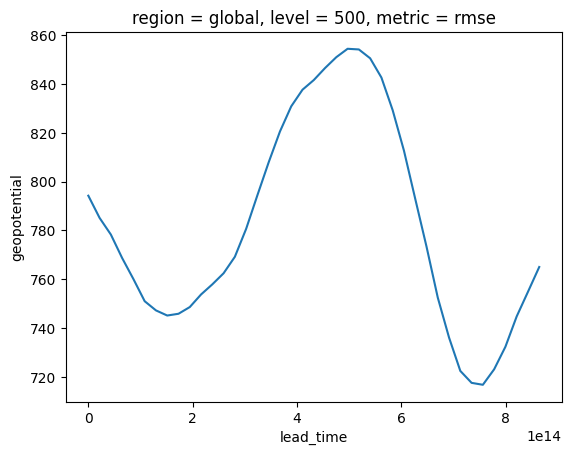

In [154]:
new_simple['geopotential'].sel(metric='rmse', level=500, region='global').plot(label='Simple Model')

Global Region

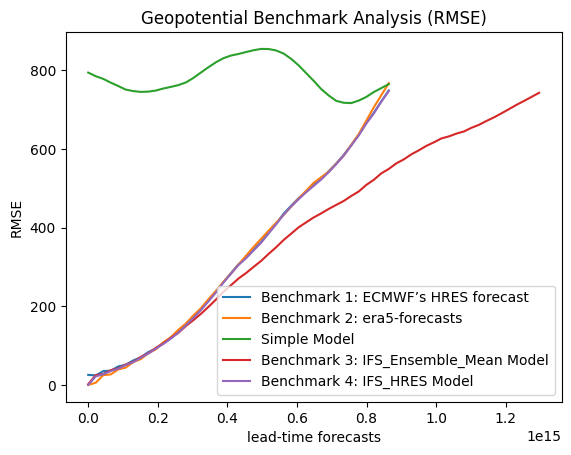

In [117]:
results1['geopotential'].sel(metric='rmse', level=500, region='global').plot(label='Benchmark 1: ECMWF’s HRES forecast')
results2['geopotential'].sel(metric='rmse', level=500, region='global').plot(label='Benchmark 2: era5-forecasts')
results4['geopotential'].sel(metric='rmse', level=500, region='global').plot(label='Simple Model')
IFS_ensemble_results['geopotential'].sel(metric='rmse', level=500, region='global').plot(label='Benchmark 3: IFS_Ensemble_Mean Model')
IFS_HRES_results['geopotential'].sel(metric='rmse', level=500, region='global').plot(label='Benchmark 4: IFS_HRES Model')
plt.title("Geopotential Benchmark Analysis (RMSE)")
plt.xlabel("lead-time forecasts")
plt.ylabel("RMSE")
plt.legend()

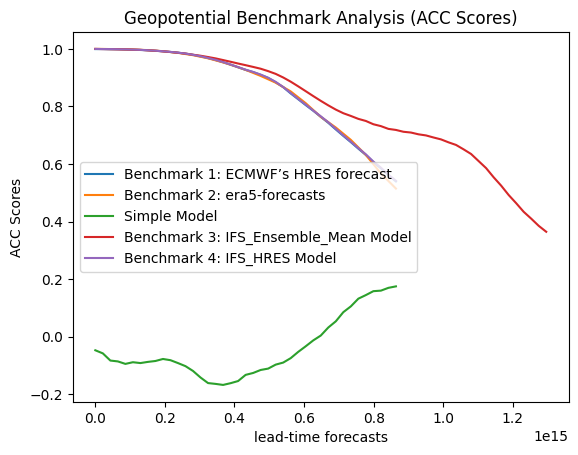

In [126]:
results1['geopotential'].sel(metric='acc', level=500, region='global').plot(label='Benchmark 1: ECMWF’s HRES forecast')
results2['geopotential'].sel(metric='acc', level=500, region='global').plot(label='Benchmark 2: era5-forecasts')
results4['geopotential'].sel(metric='acc', level=500, region='global').plot(label='Simple Model')
IFS_ensemble_results['geopotential'].sel(metric='acc', level=500, region='global').plot(label='Benchmark 3: IFS_Ensemble_Mean Model')
IFS_HRES_results['geopotential'].sel(metric='acc', level=500, region='global').plot(label='Benchmark 4: IFS_HRES Model')
plt.title("Geopotential Benchmark Analysis (ACC Scores)")
plt.xlabel("lead-time forecasts")
plt.ylabel("ACC Scores")
plt.legend()

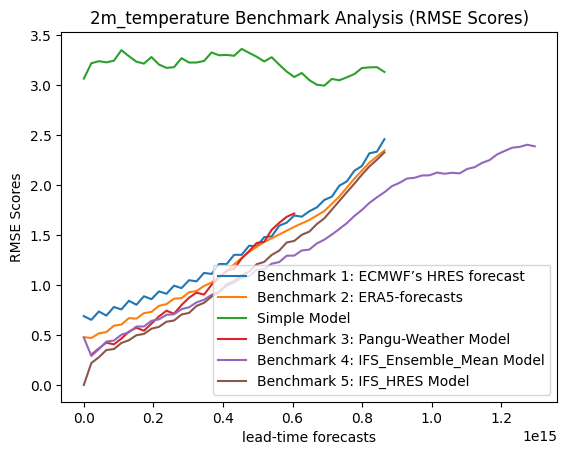

In [129]:
results1['2m_temperature'].sel(metric='rmse', region='global').plot(label='Benchmark 1: ECMWF’s HRES forecast')
results2['2m_temperature'].sel(metric='rmse', region='global').plot(label='Benchmark 2: ERA5-forecasts')
results4['2m_temperature'].sel(metric='rmse', region='global').plot(label='Simple Model')
results3['2m_temperature'].sel(metric='rmse', region='global').plot(label='Benchmark 3: Pangu-Weather Model')
IFS_ensemble_results['2m_temperature'].sel(metric='rmse', region='global').plot(label='Benchmark 4: IFS_Ensemble_Mean Model')
IFS_HRES_results['2m_temperature'].sel(metric='rmse', region='global').plot(label='Benchmark 5: IFS_HRES Model')
plt.title("2m_temperature Benchmark Analysis (RMSE Scores)")
plt.xlabel("lead-time forecasts")
plt.ylabel("RMSE Scores")
plt.legend()


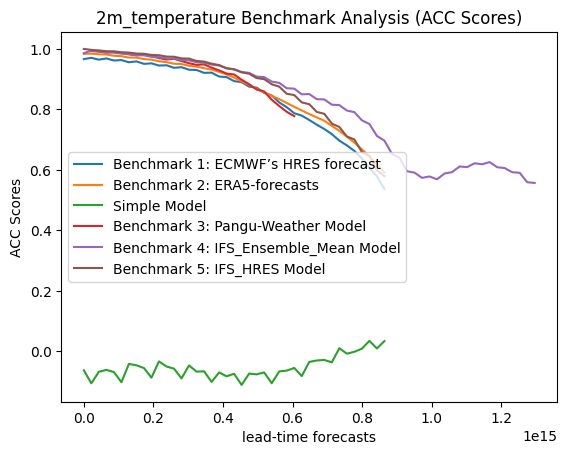

In [130]:
results1['2m_temperature'].sel(metric='acc', region='global').plot(label='Benchmark 1: ECMWF’s HRES forecast')
results2['2m_temperature'].sel(metric='acc', region='global').plot(label='Benchmark 2: ERA5-forecasts')
results4['2m_temperature'].sel(metric='acc', region='global').plot(label='Simple Model')
results3['2m_temperature'].sel(metric='acc', region='global').plot(label='Benchmark 3: Pangu-Weather Model')
IFS_ensemble_results['2m_temperature'].sel(metric='acc', region='global').plot(label='Benchmark 4: IFS_Ensemble_Mean Model')
IFS_HRES_results['2m_temperature'].sel(metric='acc', region='global').plot(label='Benchmark 5: IFS_HRES Model')
plt.title("2m_temperature Benchmark Analysis (ACC Scores)")
plt.xlabel("lead-time forecasts")
plt.ylabel("ACC Scores")
plt.legend()


Text(0, 0.5, 'RMSE Scores')

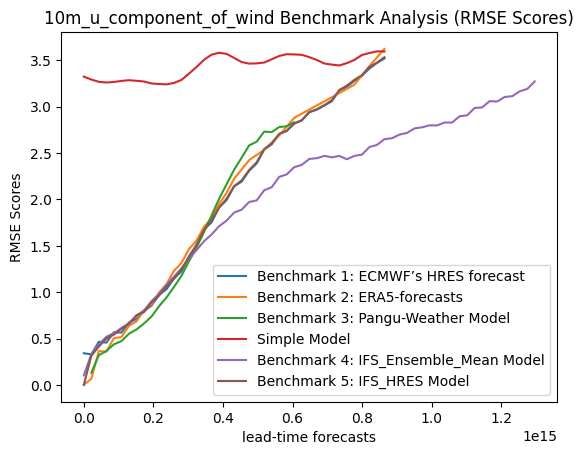

In [131]:
results1['10m_u_component_of_wind'].sel(metric='rmse', region='global').plot(label='Benchmark 1: ECMWF’s HRES forecast')
results2['10m_u_component_of_wind'].sel(metric='rmse', region='global').plot(label='Benchmark 2: ERA5-forecasts')
results3['10m_u_component_of_wind'].sel(metric='rmse', region='global').plot(label='Benchmark 3: Pangu-Weather Model')
results4['10m_u_component_of_wind'].sel(metric='rmse', region='global').plot(label='Simple Model')
IFS_ensemble_results['10m_u_component_of_wind'].sel(metric='rmse', region='global').plot(label='Benchmark 4: IFS_Ensemble_Mean Model')
IFS_HRES_results['10m_u_component_of_wind'].sel(metric='rmse', region='global').plot(label='Benchmark 5: IFS_HRES Model')
plt.legend()
plt.title("10m_u_component_of_wind Benchmark Analysis (RMSE Scores)")
plt.xlabel("lead-time forecasts")
plt.ylabel("RMSE Scores")


Text(0, 0.5, 'ACC Scores')

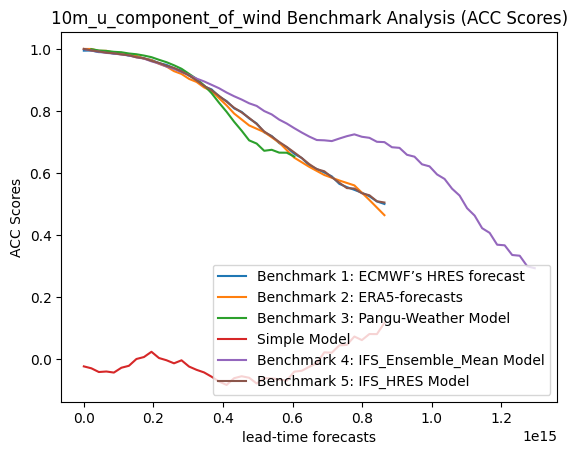

In [132]:
results1['10m_u_component_of_wind'].sel(metric='acc', region='global').plot(label='Benchmark 1: ECMWF’s HRES forecast')
results2['10m_u_component_of_wind'].sel(metric='acc', region='global').plot(label='Benchmark 2: ERA5-forecasts')
results3['10m_u_component_of_wind'].sel(metric='acc', region='global').plot(label='Benchmark 3: Pangu-Weather Model')
results4['10m_u_component_of_wind'].sel(metric='acc', region='global').plot(label='Simple Model')
IFS_ensemble_results['10m_u_component_of_wind'].sel(metric='acc', region='global').plot(label='Benchmark 4: IFS_Ensemble_Mean Model')
IFS_HRES_results['10m_u_component_of_wind'].sel(metric='acc', region='global').plot(label='Benchmark 5: IFS_HRES Model')
plt.legend()
plt.title("10m_u_component_of_wind Benchmark Analysis (ACC Scores)")
plt.xlabel("lead-time forecasts")
plt.ylabel("ACC Scores")


Text(0, 0.5, 'RMSE Scores')

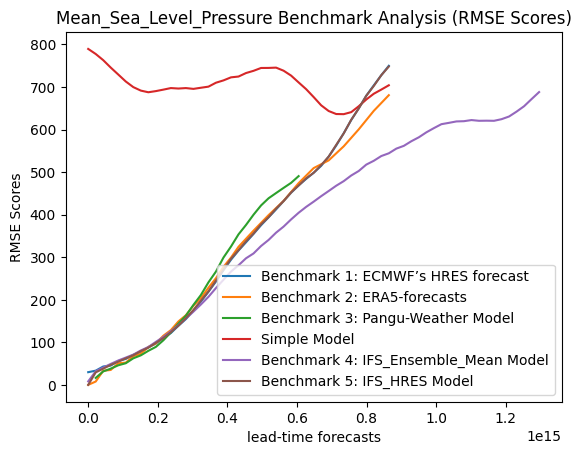

In [133]:
results1['mean_sea_level_pressure'].sel(metric='rmse', region='global').plot(label='Benchmark 1: ECMWF’s HRES forecast')
results2['mean_sea_level_pressure'].sel(metric='rmse', region='global').plot(label='Benchmark 2: ERA5-forecasts')
results3['mean_sea_level_pressure'].sel(metric='rmse', region='global').plot(label='Benchmark 3: Pangu-Weather Model')
results4['mean_sea_level_pressure'].sel(metric='rmse', region='global').plot(label='Simple Model')
IFS_ensemble_results['mean_sea_level_pressure'].sel(metric='rmse', region='global').plot(label='Benchmark 4: IFS_Ensemble_Mean Model')
IFS_HRES_results['mean_sea_level_pressure'].sel(metric='rmse', region='global').plot(label='Benchmark 5: IFS_HRES Model')
plt.legend()
plt.title("Mean_Sea_Level_Pressure Benchmark Analysis (RMSE Scores)")
plt.xlabel("lead-time forecasts")
plt.ylabel("RMSE Scores")



Text(0, 0.5, 'ACC Scores')

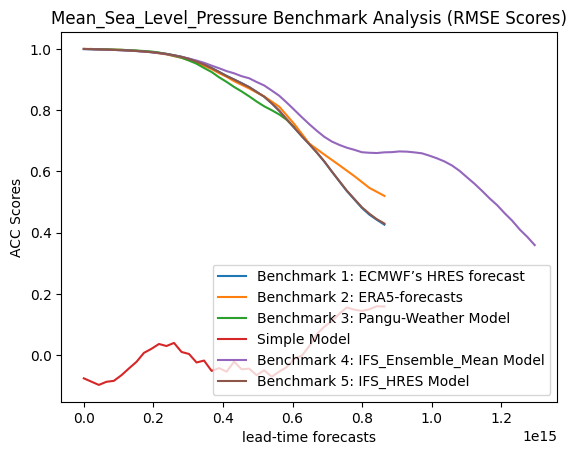

In [134]:
results1['mean_sea_level_pressure'].sel(metric='acc', region='global').plot(label='Benchmark 1: ECMWF’s HRES forecast')
results2['mean_sea_level_pressure'].sel(metric='acc', region='global').plot(label='Benchmark 2: ERA5-forecasts')
results3['mean_sea_level_pressure'].sel(metric='acc', region='global').plot(label='Benchmark 3: Pangu-Weather Model')
results4['mean_sea_level_pressure'].sel(metric='acc', region='global').plot(label='Simple Model')
IFS_ensemble_results['mean_sea_level_pressure'].sel(metric='acc', region='global').plot(label='Benchmark 4: IFS_Ensemble_Mean Model')
IFS_HRES_results['mean_sea_level_pressure'].sel(metric='acc', region='global').plot(label='Benchmark 5: IFS_HRES Model')
plt.legend()
plt.title("Mean_Sea_Level_Pressure Benchmark Analysis (RMSE Scores)")
plt.xlabel("lead-time forecasts")
plt.ylabel("ACC Scores")



Text(0, 0.5, 'ACC Scores')

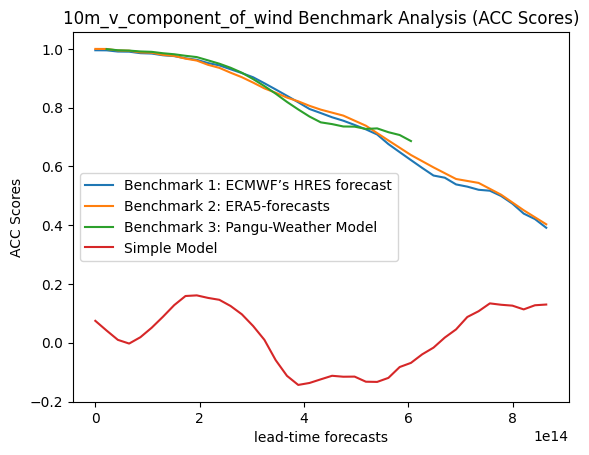

In [100]:
results1['10m_v_component_of_wind'].sel(metric='acc', region='global').plot(label='Benchmark 1: ECMWF’s HRES forecast')
results2['10m_v_component_of_wind'].sel(metric='acc', region='global').plot(label='Benchmark 2: ERA5-forecasts')
results3['10m_v_component_of_wind'].sel(metric='acc', region='global').plot(label='Benchmark 3: Pangu-Weather Model')
results4['10m_v_component_of_wind'].sel(metric='acc', region='global').plot(label='Simple Model')
plt.legend()
plt.title("10m_v_component_of_wind Benchmark Analysis (ACC Scores)")
plt.xlabel("lead-time forecasts")
plt.ylabel("ACC Scores")


Text(0, 0.5, 'RMSE Scores')

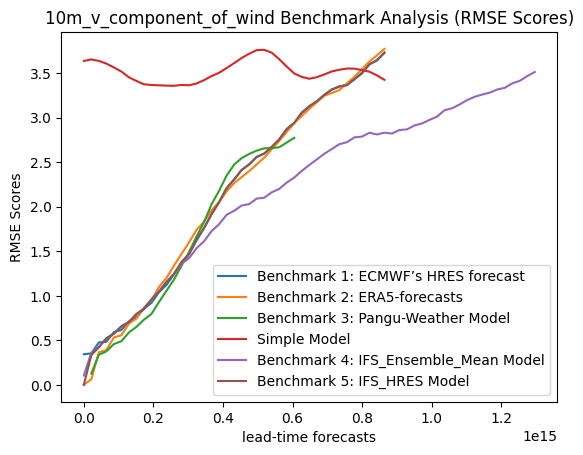

In [135]:
results1['10m_v_component_of_wind'].sel(metric='rmse', region='global').plot(label='Benchmark 1: ECMWF’s HRES forecast')
results2['10m_v_component_of_wind'].sel(metric='rmse', region='global').plot(label='Benchmark 2: ERA5-forecasts')
results3['10m_v_component_of_wind'].sel(metric='rmse', region='global').plot(label='Benchmark 3: Pangu-Weather Model')
results4['10m_v_component_of_wind'].sel(metric='rmse', region='global').plot(label='Simple Model')
IFS_ensemble_results['10m_v_component_of_wind'].sel(metric='rmse', region='global').plot(label='Benchmark 4: IFS_Ensemble_Mean Model')
IFS_HRES_results['10m_v_component_of_wind'].sel(metric='rmse', region='global').plot(label='Benchmark 5: IFS_HRES Model')
plt.legend()
plt.title("10m_v_component_of_wind Benchmark Analysis (RMSE Scores)")
plt.xlabel("lead-time forecasts")
plt.ylabel("RMSE Scores")


Text(0, 0.5, 'RMSE Scores')

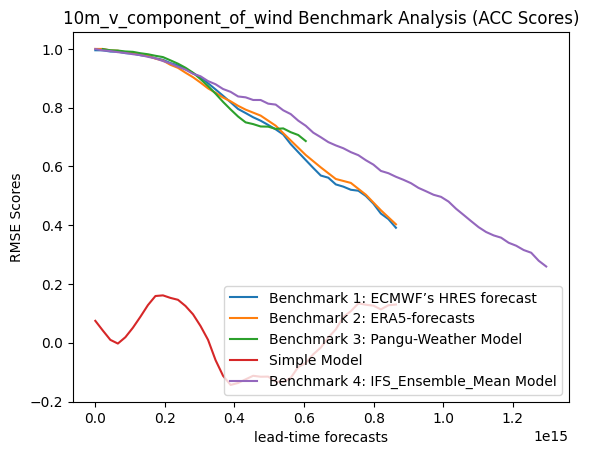

In [137]:
# Benchmarking Results:
results1['10m_v_component_of_wind'].sel(metric='acc', region='global').plot(label='Benchmark 1: ECMWF’s HRES forecast')
results2['10m_v_component_of_wind'].sel(metric='acc', region='global').plot(label='Benchmark 2: ERA5-forecasts')
results3['10m_v_component_of_wind'].sel(metric='acc', region='global').plot(label='Benchmark 3: Pangu-Weather Model')
results4['10m_v_component_of_wind'].sel(metric='acc', region='global').plot(label='Simple Model')
IFS_ensemble_results['10m_v_component_of_wind'].sel(metric='acc', region='global').plot(label='Benchmark 4: IFS_Ensemble_Mean Model')
plt.legend()
plt.title("10m_v_component_of_wind Benchmark Analysis (ACC Scores)")
plt.xlabel("lead-time forecasts")
plt.ylabel("RMSE Scores")

Tropics

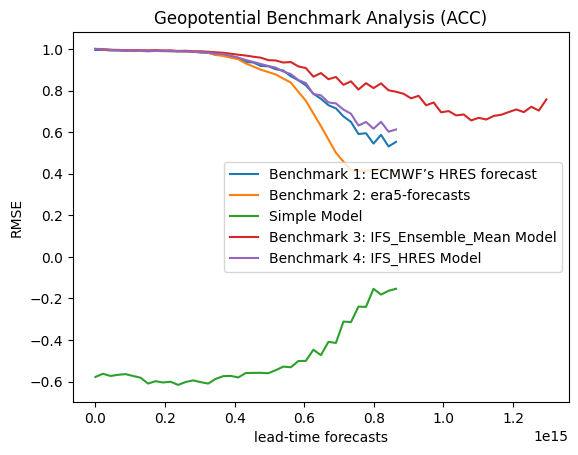

In [139]:
results1['geopotential'].sel(metric='acc', level=500, region='tropics').plot(label='Benchmark 1: ECMWF’s HRES forecast')
results2['geopotential'].sel(metric='acc', level=500, region='tropics').plot(label='Benchmark 2: era5-forecasts')
results4['geopotential'].sel(metric='acc', level=500, region='tropics').plot(label='Simple Model')
IFS_ensemble_results['geopotential'].sel(metric='acc', level=500, region='tropics').plot(label='Benchmark 3: IFS_Ensemble_Mean Model')
IFS_HRES_results['geopotential'].sel(metric='acc', level=500, region='tropics').plot(label='Benchmark 4: IFS_HRES Model')
plt.title("Geopotential Benchmark Analysis (ACC)")
plt.xlabel("lead-time forecasts")
plt.ylabel("RMSE")
plt.legend()

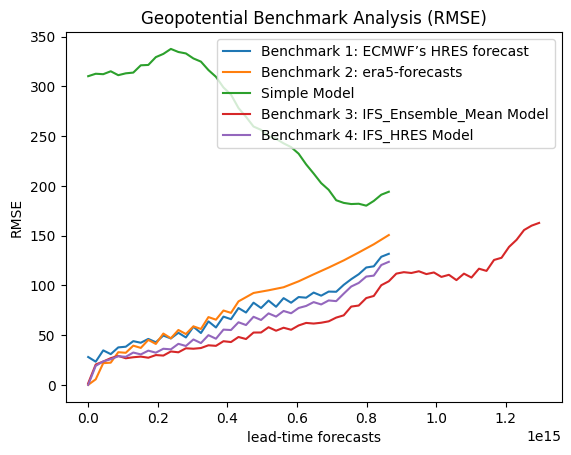

In [138]:
results1['geopotential'].sel(metric='rmse', level=500, region='tropics').plot(label='Benchmark 1: ECMWF’s HRES forecast')
results2['geopotential'].sel(metric='rmse', level=500, region='tropics').plot(label='Benchmark 2: era5-forecasts')
results4['geopotential'].sel(metric='rmse', level=500, region='tropics').plot(label='Simple Model')
IFS_ensemble_results['geopotential'].sel(metric='rmse', level=500, region='tropics').plot(label='Benchmark 3: IFS_Ensemble_Mean Model')
IFS_HRES_results['geopotential'].sel(metric='rmse', level=500, region='tropics').plot(label='Benchmark 4: IFS_HRES Model')
plt.title("Geopotential Benchmark Analysis (RMSE)")
plt.xlabel("lead-time forecasts")
plt.ylabel("RMSE")
plt.legend()

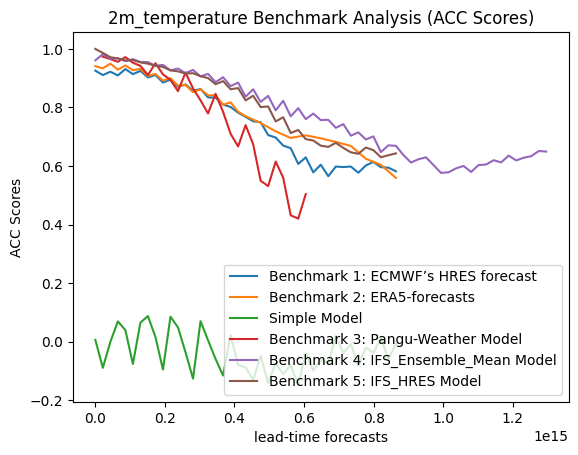

In [140]:
results1['2m_temperature'].sel(metric='acc', region='tropics').plot(label='Benchmark 1: ECMWF’s HRES forecast')
results2['2m_temperature'].sel(metric='acc', region='tropics').plot(label='Benchmark 2: ERA5-forecasts')
results4['2m_temperature'].sel(metric='acc', region='tropics').plot(label='Simple Model')
results3['2m_temperature'].sel(metric='acc', region='tropics').plot(label='Benchmark 3: Pangu-Weather Model')
IFS_ensemble_results['2m_temperature'].sel(metric='acc', region='tropics').plot(label='Benchmark 4: IFS_Ensemble_Mean Model')
IFS_HRES_results['2m_temperature'].sel(metric='acc', region='tropics').plot(label='Benchmark 5: IFS_HRES Model')
plt.title("2m_temperature Benchmark Analysis (ACC Scores)")
plt.xlabel("lead-time forecasts")
plt.ylabel("ACC Scores")
plt.legend()


Extra Tropics


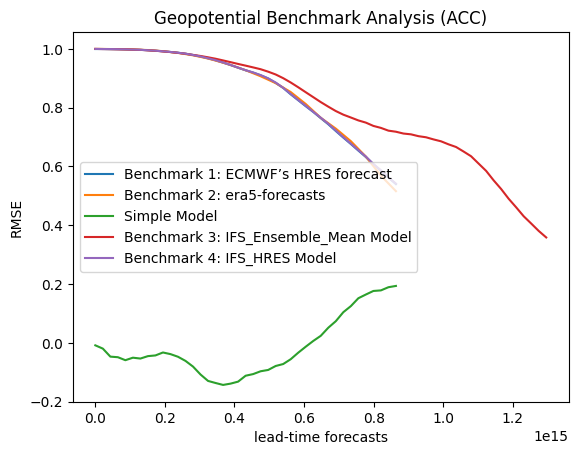

In [143]:
results1['geopotential'].sel(metric='acc', level=500, region='extra-tropics').plot(label='Benchmark 1: ECMWF’s HRES forecast')
results2['geopotential'].sel(metric='acc', level=500, region='extra-tropics').plot(label='Benchmark 2: era5-forecasts')
results4['geopotential'].sel(metric='acc', level=500, region='extra-tropics').plot(label='Simple Model')
IFS_ensemble_results['geopotential'].sel(metric='acc', level=500, region='extra-tropics').plot(label='Benchmark 3: IFS_Ensemble_Mean Model')
IFS_HRES_results['geopotential'].sel(metric='acc', level=500, region='extra-tropics').plot(label='Benchmark 4: IFS_HRES Model')
plt.title("Geopotential Benchmark Analysis (ACC)")
plt.xlabel("lead-time forecasts")
plt.ylabel("RMSE")
plt.legend()

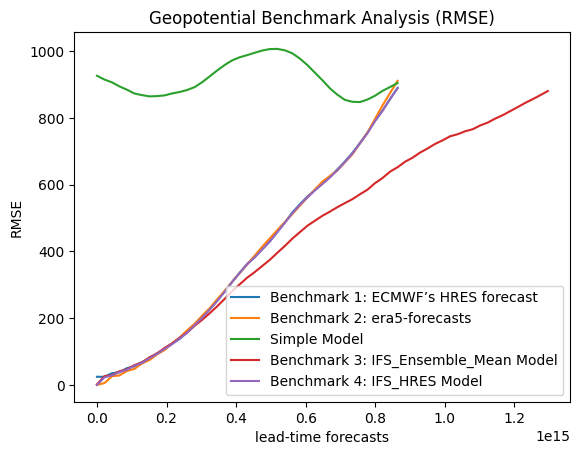

In [144]:
results1['geopotential'].sel(metric='rmse', level=500, region='extra-tropics').plot(label='Benchmark 1: ECMWF’s HRES forecast')
results2['geopotential'].sel(metric='rmse', level=500, region='extra-tropics').plot(label='Benchmark 2: era5-forecasts')
results4['geopotential'].sel(metric='rmse', level=500, region='extra-tropics').plot(label='Simple Model')
IFS_ensemble_results['geopotential'].sel(metric='rmse', level=500, region='extra-tropics').plot(label='Benchmark 3: IFS_Ensemble_Mean Model')
IFS_HRES_results['geopotential'].sel(metric='rmse', level=500, region='extra-tropics').plot(label='Benchmark 4: IFS_HRES Model')
plt.title("Geopotential Benchmark Analysis (RMSE)")
plt.xlabel("lead-time forecasts")
plt.ylabel("RMSE")
plt.legend()

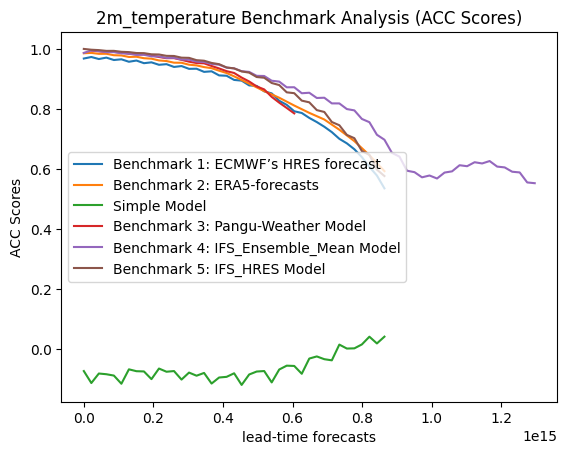

In [145]:
results1['2m_temperature'].sel(metric='acc', region='extra-tropics').plot(label='Benchmark 1: ECMWF’s HRES forecast')
results2['2m_temperature'].sel(metric='acc', region='extra-tropics').plot(label='Benchmark 2: ERA5-forecasts')
results4['2m_temperature'].sel(metric='acc', region='extra-tropics').plot(label='Simple Model')
results3['2m_temperature'].sel(metric='acc', region='extra-tropics').plot(label='Benchmark 3: Pangu-Weather Model')
IFS_ensemble_results['2m_temperature'].sel(metric='acc', region='extra-tropics').plot(label='Benchmark 4: IFS_Ensemble_Mean Model')
IFS_HRES_results['2m_temperature'].sel(metric='acc', region='extra-tropics').plot(label='Benchmark 5: IFS_HRES Model')
plt.title("2m_temperature Benchmark Analysis (ACC Scores)")
plt.xlabel("lead-time forecasts")
plt.ylabel("ACC Scores")
plt.legend()
